# CARE Denoising with the Planaria Dataset
This notebook demonstrates CARE denoising on the Planaria dataset using NPZ (array) format for training data, and TIF images for the test data. The training dataset consists of corresponding low and high image patches, and the test set has three low conditions (C1, C2, C3) and a GT condition.

In [17]:
#necessary imports
import tarfile
from pathlib import Path
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
from careamics import CAREamist
from careamics.config import create_care_configuration

# Utility function for visualization
def visualize_images(img1, img2, title1="Low", title2="High"):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img1, cmap='gray')
    ax[0].set_title(title1)
    ax[0].axis('off')
    
    ax[1].imshow(img2, cmap='gray')
    ax[1].set_title(title2)
    ax[1].axis('off')
    
    plt.show()


## Load the Training Data (NPZ Format)

In [18]:
# Load the training data from the NPZ file
train_data_path = "./train_data/data_label.npz"
train_data = np.load(train_data_path)

# Extract low (X) and high (Y) condition images
X_train = train_data['X']
Y_train = train_data['Y']

print(f"Training data loaded. X shape: {X_train.shape}, Y shape: {Y_train.shape}")


Training data loaded. X shape: (17900, 1, 16, 64, 64), Y shape: (17900, 1, 16, 64, 64)


## Visualize a Sample from the Training Data

In [16]:
# Visualize a slice from the training data
slice_idx = 0  # You can change this to view different slices
visualize_images(X_train[slice_idx, 0, 0, :, :], Y_train[slice_idx, 0, 0, :, :], title1="Low Condition", title2="High Condition")


NameError: name 'visualize_images' is not defined

## Load the Test Data (TIF Format)

In [4]:
# Load test data (condition_1, condition_2, condition_3, and GT) from TIF files
test_data_dir = Path("./test_data")
conditions = ["condition_1", "condition_2", "condition_3", "GT"]

test_images = {}
for condition in conditions:
    test_images[condition] = []
    condition_dir = test_data_dir / condition
    tif_files = sorted(condition_dir.glob("*.tif"))
    
    for tif_file in tif_files:
        img = tiff.imread(tif_file)
        test_images[condition].append(img)
    
    # Do not convert to np.array, keep as a list due to variable image sizes
    print(f"Loaded {len(test_images[condition])} images from {condition}")


Loaded 20 images from condition_1
Loaded 20 images from condition_2
Loaded 20 images from condition_3
Loaded 20 images from GT


## Visualize a Sample from the Test Data

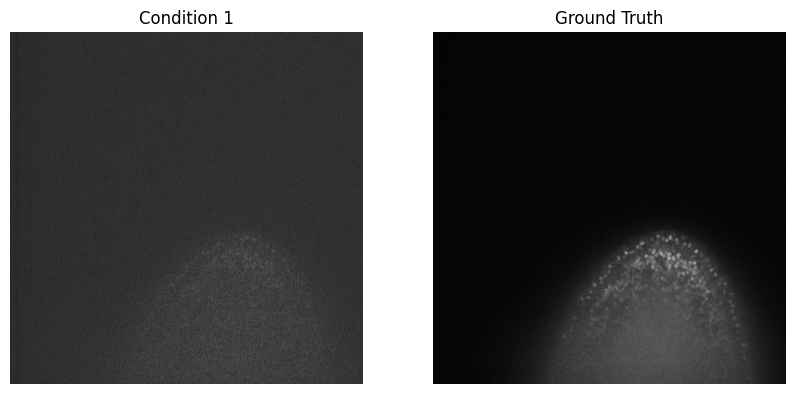

In [5]:
# Visualize a specific slice from a 3D image stack (Condition 1 and Ground Truth)
test_idx = 0 
slice_idx = 0 

# Extract one 2D slice from the 3D test image and ground truth
condition1_slice = test_images['condition_1'][test_idx][slice_idx, :, :]
gt_slice = test_images['GT'][test_idx][slice_idx, :, :]

# Visualize the 2D slices
visualize_images(condition1_slice, gt_slice, title1="Condition 1", title2="Ground Truth")


## Configure CARE Denoising Model

In [13]:
# Initialize wandb
import wandb
wandb.init(project="CARE_denoising", name="CARE_Planaria_run")

#config
config = create_care_configuration(
    experiment_name="CARE_planaria",
    data_type="array",  
    axes="ZYX", 
    patch_size=(16, 64, 64), 
    batch_size=16,
    num_epochs=10,
    n_channels_in=1,  
    n_channels_out=1,  
    independent_channels=False
)
config.data_config.axes = "SCZYX" #workaround

## Train the CARE Denoising Model

In [14]:
careamist = CAREamist(source=config) #start training

# Train using the low (X) and high (Y) pairs
careamist.train(
    train_source=X_train,
    train_target=Y_train,
    val_percentage=0.01,
    val_minimum_split=20
)

No working directory provided. Using current working directory: /home/diya.srivastava/Downloads/Denoising_Planaria.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA A40-8Q') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for perfor

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 1108/1108 [02:23<00:00,  7.73it/s, train_loss_step=0.235, val_loss=0.26, train_loss_epoch=0.272] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1108/1108 [02:23<00:00,  7.71it/s, train_loss_step=0.235, val_loss=0.26, train_loss_epoch=0.272]


loading last checkpoint first before we continue

In [2]:
from careamics import CAREamist
checkpoint_path = '/home/diya.srivastava/Downloads/Denoising_Planaria/checkpoints/last-v2.ckpt' # Path to the saved checkpoint for when you get disconnected, change to the last checkpoint
careamist = CAREamist(source=checkpoint_path)

No working directory provided. Using current working directory: /home/diya.srivastava/Downloads/Denoising_Planaria.
/home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/careamics/model_io/model_io_utils.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control

## Prediction with CAREamics

In [3]:
from pathlib import Path

test_data_dir = Path("/home/diya.srivastava/Downloads/Denoising_Planaria/test_data")

# Adjust the axes to reflect the 3D shape
careamist.cfg.data_config.axes = "ZYX"

# Tiling prediction - maybe need to fix this
predictions = careamist.predict(
    source=test_data_dir / "condition_1",  
    data_type="tiff", 
    tile_size=(16, 128, 128),
    tile_overlap=(8, 32, 32), 
    batch_size=1, 
    tta=False  
)

# Output the shape of the prediction for each test file
for i, pred in enumerate(predictions):
    print(f"Prediction {i} shape: {pred.shape}")

You are using a CUDA device ('NVIDIA A40-8Q') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Prediction 0 shape: (1, 1, 95, 1024, 1024)
Prediction 1 shape: (1, 1, 95, 1024, 1024)
Prediction 2 shape: (1, 1, 95, 1024, 1024)
Prediction 3 shape: (1, 1, 95, 1024, 1024)
Prediction 4 shape: (1, 1, 95, 1024, 1024)
Prediction 5 shape: (1, 1, 95, 1024, 1024)
Prediction 6 shape: (1, 1, 95, 1024, 1024)
Prediction 7 shape: (1, 1, 95, 1024, 1024)
Prediction 8 shape: (1, 1, 95, 1024, 1024)
Prediction 9 shape: (1, 1, 95, 1024, 1024)
Prediction 10 shape: (1, 1, 95, 1024, 1024)
Prediction 11 shape: (1, 1, 95, 1024, 1024)
Prediction 12 shape: (1, 1, 95, 1024, 1024)
Prediction 13 shape: (1, 1, 95, 1024, 1024)
Prediction 14 shape: (1, 1, 95, 1024, 1024)
Prediction 15 shape: (1, 1, 95, 1024, 1024)
Prediction 16 shape: (1, 1, 68, 1024, 1024)
Prediction 17 shape: (1, 1, 38, 1024, 1024)
Prediction 18 shape: (1, 1, 60, 1024, 1024)
Prediction 19 shape: (1, 1, 26, 1024, 1024)


## Visualize Predictions vs Ground Truth

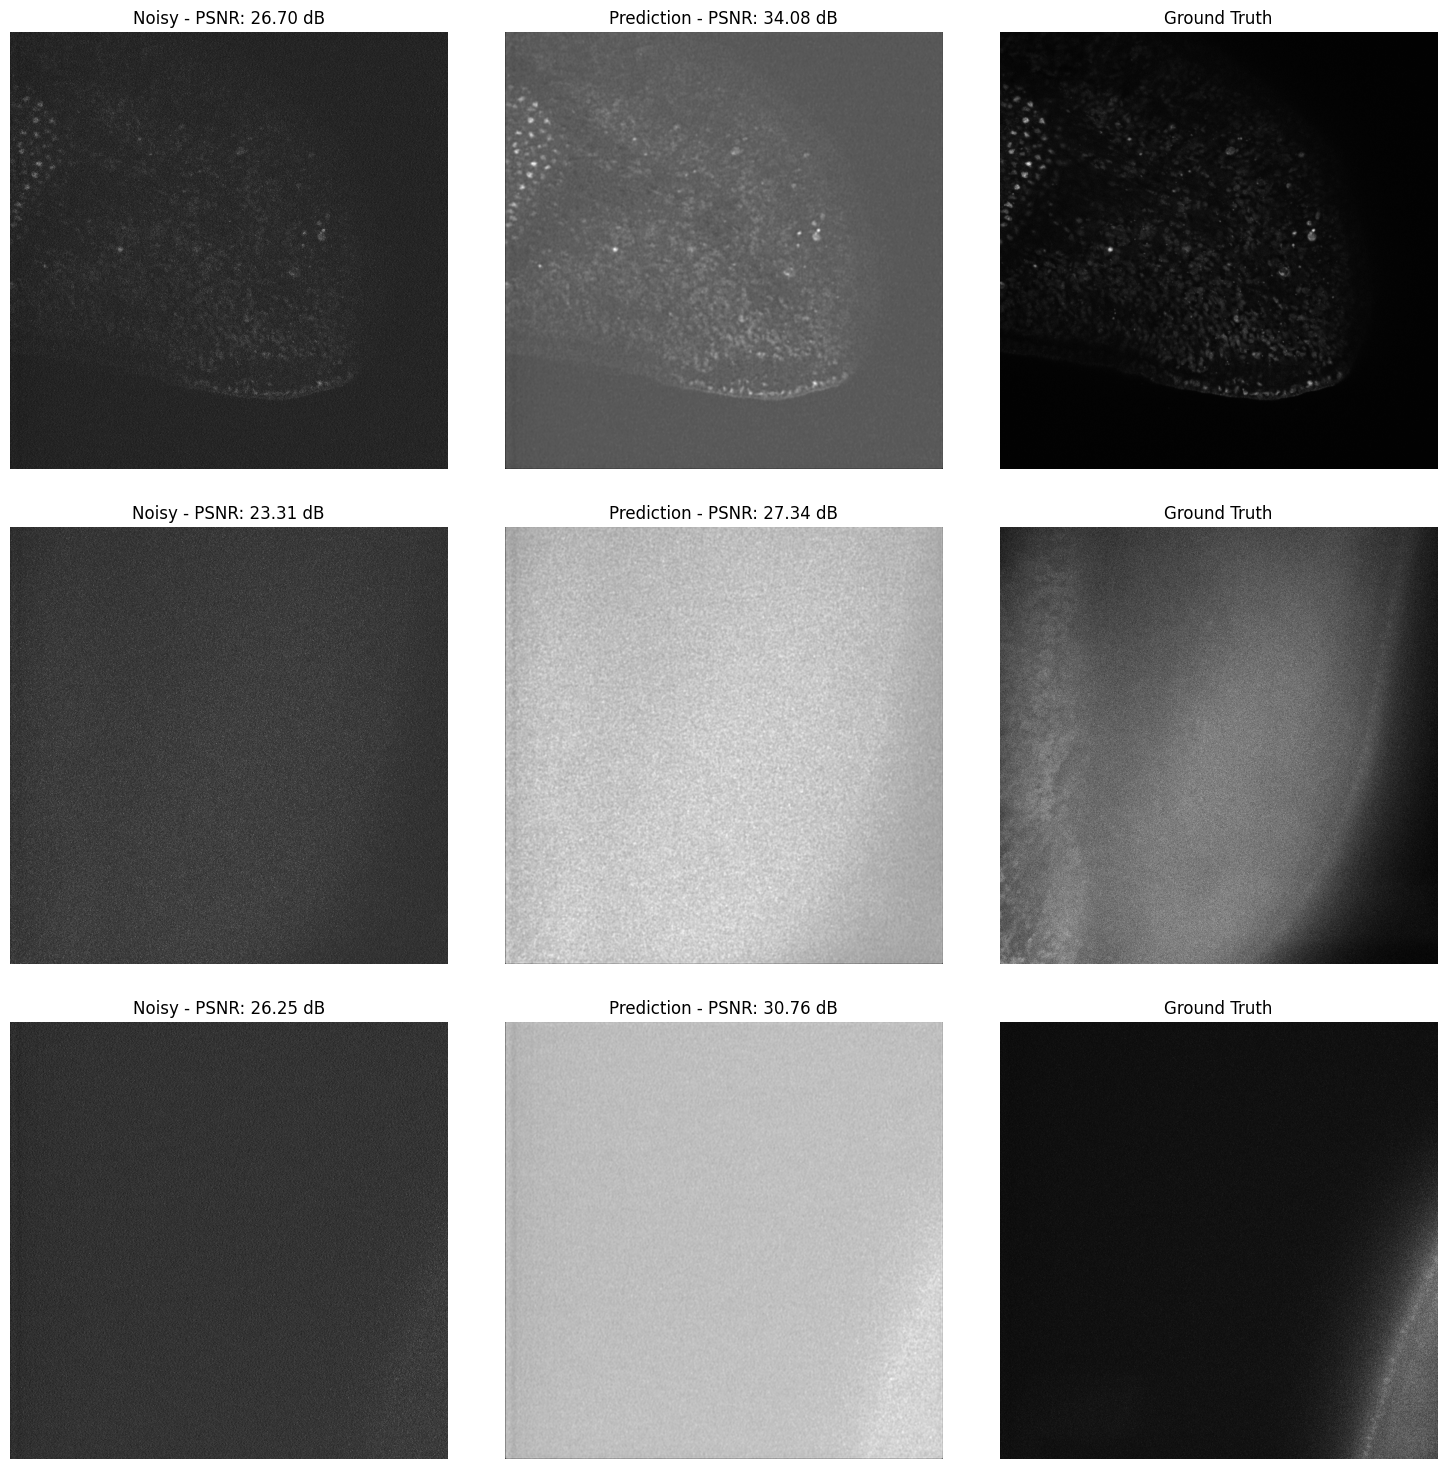

In [11]:
#re-import when loading from last checkpoint
import matplotlib.pyplot as plt
import numpy as np
import random
import tifffile 
from pathlib import Path
from careamics.utils.metrics import scale_invariant_psnr

# Paths to the test images
test_data_dir = Path("/home/diya.srivastava/Downloads/Denoising_Planaria/test_data")
condition_1_path = test_data_dir / "condition_1"
gt_path = test_data_dir / "GT"
noisy_files = sorted(condition_1_path.glob("*.tif*"))
gt_files = sorted(gt_path.glob("*.tif*"))
noisy_images = [tifffile.imread(str(f)) for f in noisy_files]
gt_images = [tifffile.imread(str(f)) for f in gt_files]

# Randomly select 3 images to visualize - inspo from U20S_CARE.ipynb
selected_indices = random.sample(range(len(gt_images)), 3)
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
fig.tight_layout()

# Process and plot each selected image
for i, idx in enumerate(selected_indices):
    pred_image = predictions[idx].squeeze()
    slice_idx = min(10, noisy_images[idx].shape[0] - 1)  # Select a slice index

    # Extract slices for visualization
    noisy_slice = noisy_images[idx][slice_idx, :, :].astype(np.float32)
    pred_slice = pred_image[slice_idx, :, :].astype(np.float32)
    gt_slice = gt_images[idx][slice_idx, :, :].astype(np.float32)

    # Calculate PSNR for noisy vs. GT and prediction vs. GT - refer to metrics.py
    psnr_noisy = scale_invariant_psnr(noisy_slice, gt_slice)
    psnr_pred = scale_invariant_psnr(pred_slice, gt_slice)

    # Plot noisy slice
    ax[i, 0].imshow(noisy_slice, cmap='gray')
    ax[i, 0].set_title(f"Noisy - PSNR: {psnr_noisy:.2f} dB")
    ax[i, 0].axis('off')

    # Plot predicted slice
    ax[i, 1].imshow(pred_slice, cmap='gray')
    ax[i, 1].set_title(f"Prediction - PSNR: {psnr_pred:.2f} dB")
    ax[i, 1].axis('off')

    # Plot ground truth slice
    ax[i, 2].imshow(gt_slice, cmap='gray')
    ax[i, 2].set_title("Ground Truth")
    ax[i, 2].axis('off')

plt.show()


## Visualizing the same slice in the test data above in cell [5] ## 

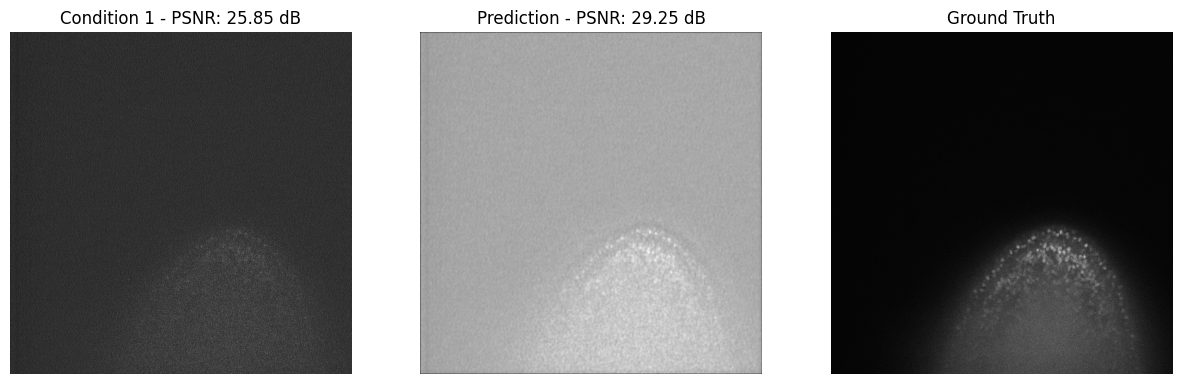

In [15]:
# Visualize the specific slice after prediction
test_idx = 0  
slice_idx = 0  

# Extract the specific slice from Condition 1 (noisy), Prediction, and Ground Truth
condition1_slice = noisy_images[test_idx][slice_idx, :, :].astype(np.float32)
pred_slice = predictions[test_idx][0, 0, slice_idx, :, :].astype(np.float32)
gt_slice = gt_images[test_idx][slice_idx, :, :].astype(np.float32)

#psnr calculation
psnr_noisy = scale_invariant_psnr(condition1_slice, gt_slice)
psnr_pred = scale_invariant_psnr(pred_slice, gt_slice)

# Plot the Condition 1 (noisy), Prediction, and Ground Truth slices with PSNR values
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Plot Condition 1 (noisy input)
ax[0].imshow(condition1_slice, cmap='gray')
ax[0].set_title(f"Condition 1 - PSNR: {psnr_noisy:.2f} dB")
ax[0].axis('off')

# Plot Prediction
ax[1].imshow(pred_slice, cmap='gray')
ax[1].set_title(f"Prediction - PSNR: {psnr_pred:.2f} dB")
ax[1].axis('off')

# Plot Ground Truth
ax[2].imshow(gt_slice, cmap='gray')
ax[2].set_title("Ground Truth")
ax[2].axis('off')

plt.show()
